# Income Predictor
**Goal: Predict whether someone makes over 50k or below 50k**
### Description

In [1]:
import pandas as pd
import numpy as np
import sklearn
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
warnings.filterwarnings("ignore") 

## Load data for training / testing

In [2]:
def load_data(path):
    return pd.read_csv(path)

In [3]:
df_train = load_data('../data/au_train.csv')
df_test = load_data('../data/au_test.csv')

## Exploratory Data Analysis
While some information was provided on the set of instructions for this project, there have been countless times I've found discrepencies between the documentation for the dataset and the dataset itself. Even if all looks good on a high level, it is always helpful to understand our data to the fullest potential.

In [4]:
print("Shape of the training set: {}. Shape of the test set: {}.".format(df_train.shape, df_test.shape))
print("Columns names:", list(df_train.columns))

Shape of the training set: (32561, 15). Shape of the test set: (16281, 15).
Columns names: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class']


In [5]:
# check for null values
print(df_train.isnull().any())

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
class             False
dtype: bool


### Plotting feature distribution (numerical)

In [6]:
# print out general statistics for the numerical predictors
df_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
def boxplot(df, num_columns, num_rows, l):
    '''
    Input: df (dataframe), num_columns (how many columns you would like in your resulting figure),
           num_rows (how many rows you would like in your resulting figure), l (relevant column names)
    Output: Boxplot of distribution for the relevant columns, l
    '''
    plt.figure(figsize=(num_columns*2,5*num_rows))
    for i in range(0,len(l)):
        plt.subplot(num_rows + 1,num_columns,i+1)
        sns.set_style('whitegrid')
        sns.boxplot(y=df[l[i]], color='seagreen')
        plt.tight_layout()

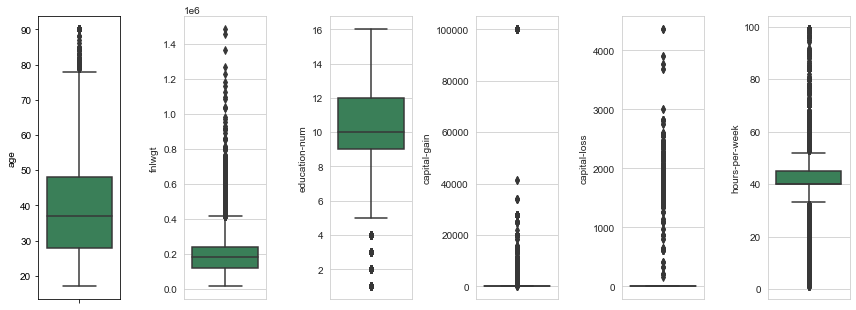

In [8]:
# plotting numerical features in a boxplot
l = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
number_of_columns = len(l)
number_of_rows = int(len(l) - 1 / number_of_columns)

boxplot(df_train, number_of_columns, number_of_rows, l)

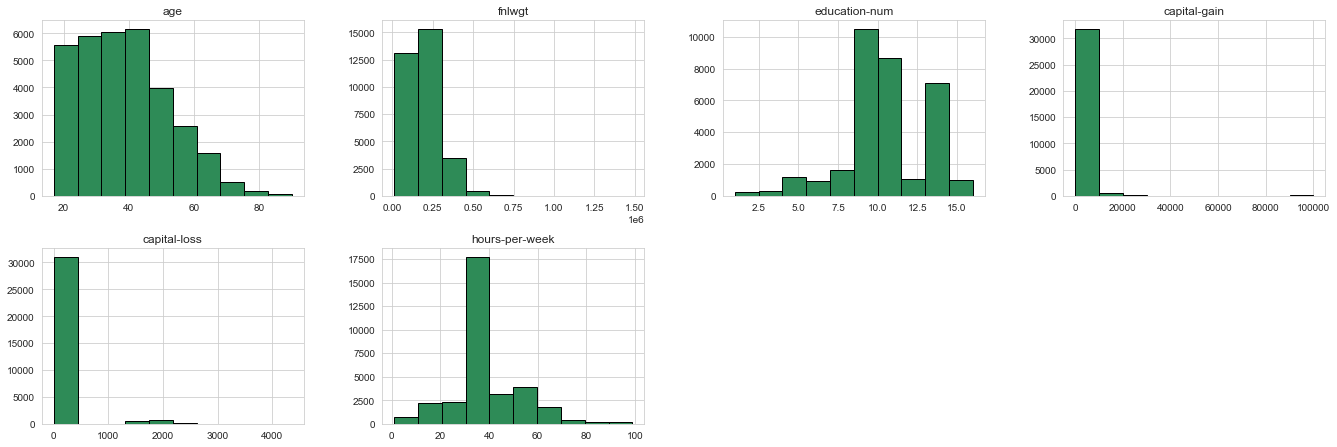

In [9]:
# plotting numerical features in a histogram
subplot = df_train.hist(layout=(5,4), figsize=(23,20), color='seagreen', edgecolor='black')

In [10]:
def kde(df, number_of_columns, number_of_rows, l):
    '''
    Kernal Density Estimator
    Input: df (dataframe), num_columns (how many columns you would like in your resulting figure),
           num_rows (how many rows you would like in your resulting figure), l (relevant column names)
    Output: Boxplot of distribution for the relevant columns, l
    '''
    plt.figure(figsize=(number_of_columns*2,5*number_of_rows))
    for i in range(0,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.set_style('whitegrid')
        sns.kdeplot(df[l[i]], color='seagreen', fill=True)
        plt.tight_layout()

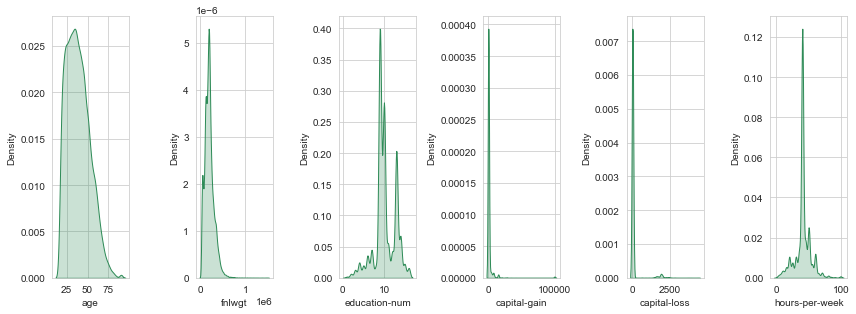

In [11]:
#l = df.columns.values[2:8] #selecting the first few numerical columns in the dataset
number_of_columns=len(l)
number_of_rows = int(len(l) - 1 / number_of_columns)

kde(df_train, number_of_columns, number_of_rows, l)

### Examining correlation between numerical features
Normally it is best practice to drop any information that is highly correlated because highly correlated values can negatively impact the training process

In [12]:
df_train.corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


<AxesSubplot:>

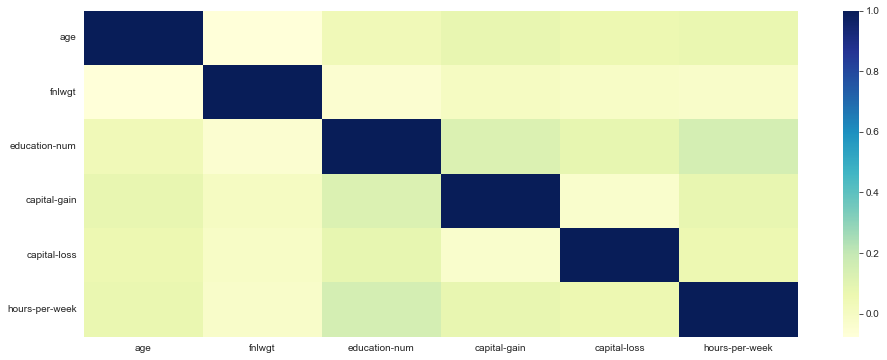

In [13]:
plt.figure(figsize=(16,6))
sns.heatmap(df_train.corr(), cmap="YlGnBu")

### Plotting features distribution (categorical)

In [14]:
def plot_distribution(df, preds):
    '''
    Plots distribution of categorical variables
    '''
    fig, axes = plt.subplots(1, len(preds), figsize=(20, len(preds)))
    for i, pred in enumerate(preds):
        df[pred].value_counts().plot(ax=axes[i], kind='bar', grid=True, title=pred, rot=75, color='seagreen')

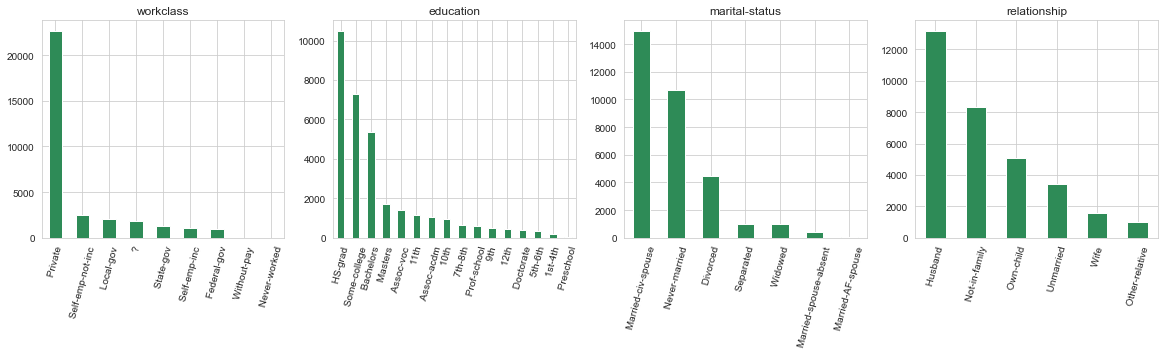

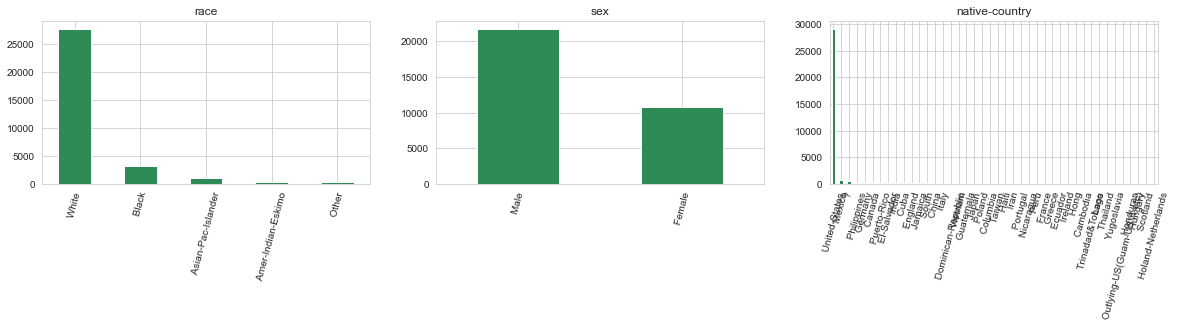

In [15]:
plot_distribution(df_train, ['workclass', 'education', 'marital-status', 'relationship'])
plot_distribution(df_train, ['race', 'sex', 'native-country'])

<AxesSubplot:title={'center':'class'}>

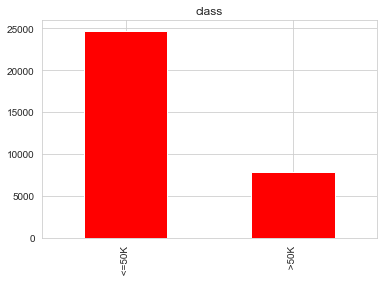

In [16]:
# plotting target variable distribution
df_train['class'].value_counts().plot(kind='bar', grid=True, title="class", color="red")

## Feature Engineering

In [17]:
# might want to scale the numerical data
#from sklearn import preprocessing
#df_scaled = preprocessing.scale(df_train)
#df_train_scaled = pd.DataFrame(df_scaled, columns=df_train.columns)

In [18]:
def one_hot_encode(df, columns):
    '''
    Handles categorical inputs by creating a binary feature for each possible category,
    assigning a value of 1 for the feature that corresponds to the original category and 0
    for the remaining
    '''
    return pd.get_dummies(df, columns=columns)

In [19]:
def binarize_lbls(labels):
    '''
    '''
    lb = LabelBinarizer()
    return pd.DataFrame(lb.fit_transform(labels), columns=['class'])

In [20]:
# converting categorical values to numerical values
categorical_columns = ['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country', 'occupation']
df_train_encoded = one_hot_encode(df_train, categorical_columns)

df_train_encoded.columns = map(str.lower, df_train_encoded.columns)

df_test_encoded = one_hot_encode(df_test, categorical_columns)
df_test_encoded.columns = map(str.lower, df_test_encoded.columns)

# dropping labels from feature set
x_train = df_train_encoded.drop(['class'], axis=1)
x_test = df_test_encoded.drop(['class'], axis=1)


In [21]:
y_train = binarize_lbls(df_train['class'])
y_test = binarize_lbls(df_test['class'])

###### In the test set, there is no one that is from Holand-Netherlands and that is throwing the model off because this existed in training
Adding this column to the x_test


In [22]:
x_test['native-country_ holand-netherlands'] = 0

In [23]:
# standardizes the data by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)

## Building a RandomForest classifer 

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
model = RandomForestClassifier(verbose=1)
model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished


RandomForestClassifier(verbose=1)

In [26]:
feature_importances = pd.DataFrame(model.feature_importances_, index = x_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[:10]

,importance
fnlwgt,0.162957
age,0.148604
capital-gain,0.096439
hours-per-week,0.082183
education-num,0.065980
marital-status_ married-civ-spouse,0.059482
relationship_ husband,0.040456
capital-loss,0.030057
marital-status_ never-married,0.024583
occupation_ exec-managerial,0.020136


In [27]:
model.score(x_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


0.8465081997420306

In [28]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(18, 2), random_state=1)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.8153676064123825

In [29]:
x_train = x_train.drop(list(feature_importances.importance[-80:].index), axis=1)
x_test = x_test.drop(list(feature_importances.importance[-80:].index), axis=1)

In [30]:
x_test.shape
x_train.shape

(32561, 28)

In [31]:
model = RandomForestClassifier(verbose=1)
model.fit(x_train, y_train)
model.score(x_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


0.8483508384005897

In [32]:
from sklearn.neural_network import MLPClassifier

In [33]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(18, 2), random_state=1)

In [34]:
clf.fit(x_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(18, 2), random_state=1,
              solver='lbfgs')

In [35]:
clf.score(x_test, y_test)

0.8585467723112831

In [42]:
from tensorflow.keras.optimizers import SGD

epochs=60
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [43]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation

# build the model
input_dim = x_train.shape[1]
num_classes = 1

lr_model = Sequential()
lr_model.add(Dense(64, activation='sigmoid', kernel_initializer='uniform', input_dim = input_dim)) 
lr_model.add(Dropout(0.1))
lr_model.add(Dense(64, kernel_initializer='uniform', activation='sigmoid'))
lr_model.add(Dense(num_classes, kernel_initializer='uniform', activation='sigmoid'))

# compile the model
lr_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [44]:
lr_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1856      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,081
Trainable params: 6,081
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Fit the model
print(input_dim)
batch_size = int(input_dim/100)
print(batch_size)

28
0


In [46]:
print(y_train.shape)

(32561, 1)


In [47]:

lr_model_history = lr_model.fit(x_train, y_train,
                    batch_size=5,
                    epochs=epochs,
                    verbose=1)

Epoch 1/60
6513/6513 [==============================] - 5s 761us/step - loss: 0.3518 - acc: 0.8364
Epoch 2/60
6513/6513 [==============================] - 5s 760us/step - loss: 0.3285 - acc: 0.8470
Epoch 3/60
6513/6513 [==============================] - 5s 769us/step - loss: 0.3237 - acc: 0.8469
Epoch 4/60
6513/6513 [==============================] - 5s 764us/step - loss: 0.3206 - acc: 0.8505
Epoch 5/60
6513/6513 [==============================] - 5s 761us/step - loss: 0.3178 - acc: 0.8499
Epoch 6/60
6513/6513 [==============================] - 5s 759us/step - loss: 0.3155 - acc: 0.8519
Epoch 7/60
6513/6513 [==============================] - 5s 762us/step - loss: 0.3148 - acc: 0.8519
Epoch 8/60
6513/6513 [==============================] - 5s 764us/step - loss: 0.3126 - acc: 0.8533
Epoch 9/60
6513/6513 [==============================] - 5s 763us/step - loss: 0.3115 - acc: 0.8538
Epoch 10/60
6513/6513 [==============================] - 5s 758us/step - loss: 0.3115 - acc: 0.8558
Epoch 11/